In [2]:
# Install catalax
# !pip install catalax

In [3]:
import numpy as np
import jax.numpy as jnp

import catalax as ctx
import catalax.mcmc as cmc

import brainunit as u

In [4]:
model = ctx.Model(name="Non-Observable Menten Inhibition")

# Define the term function
def f(t, y, args):
    K_m, k_cat, k_d = args
    s1, e1 = y
    d_s1 = - (e1 * k_cat * s1) / (K_m + s1)
    d_e1 = -k_d * e1
    return [d_s1 / u.second, d_e1 / u.second]

# Add term
model.add_term(f)

# Another way of adding species (symbols and names at the same type)
model.add_species(
    s1="Substrate",
    e1="Enzyme",
)

# In this application 'e1' is not observable and thus
# 'k_d' needs to be inferred implicitly from the data.
model.add_ode("s1", "- e1 * k_cat * s1 / (s1 + K_m)")
model.add_ode("e1", "-k_d", observable=False)

model.parameters.K_m.value = 100.0 * u.molar
model.parameters.k_cat.value = 10.0 * u.katal
model.parameters.k_d.value = 0.0001 / u.second

model

Model summary


Eq(x, Matrix([[s1, e1]]))

Eq(theta, Matrix([[k_cat, K_m, k_d]]))

Eq(Derivative(Substrate, t), -e1*k_cat*s1/(K_m + s1))

Eq(Derivative(Enzyme, t), -k_d)

,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound
0,K_m,K_m,100. * molar,False,None,None,None,None
1,k_cat,k_cat,10. * katal,False,None,None,None,None
2,k_d,k_d,1.e-04 * becquerel,False,None,None,None,None


In [5]:
# Create some dummy data to test
initial_conditions = [
    {"s1": 10.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 50.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 75.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 100.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 200.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 300.0 * u.katal, "e1": 0.1 * u.molar},
    {"s1": 400.0 * u.katal, "e1": 0.1 * u.molar},
]

time, states = model.simulate(
    initial_conditions=initial_conditions,
    dt0=0.1 * u.second, t0=0 * u.second, t1=1000 * u.second, nsteps=10, in_axes=(0, None, None),
)

# Add some noise to the data
print(states)
states = (states + states.to_decimal(u.katal) * np.random.normal(0, 0.02)).clip(min=0)

# Truncate data to only include s1
data = states[:, :, 1]

print(f"Time: {time.shape} | Data: {data.shape}")

UnitMismatchError: Cannot convert to a unit with different dimensions. (units are kat and M ).

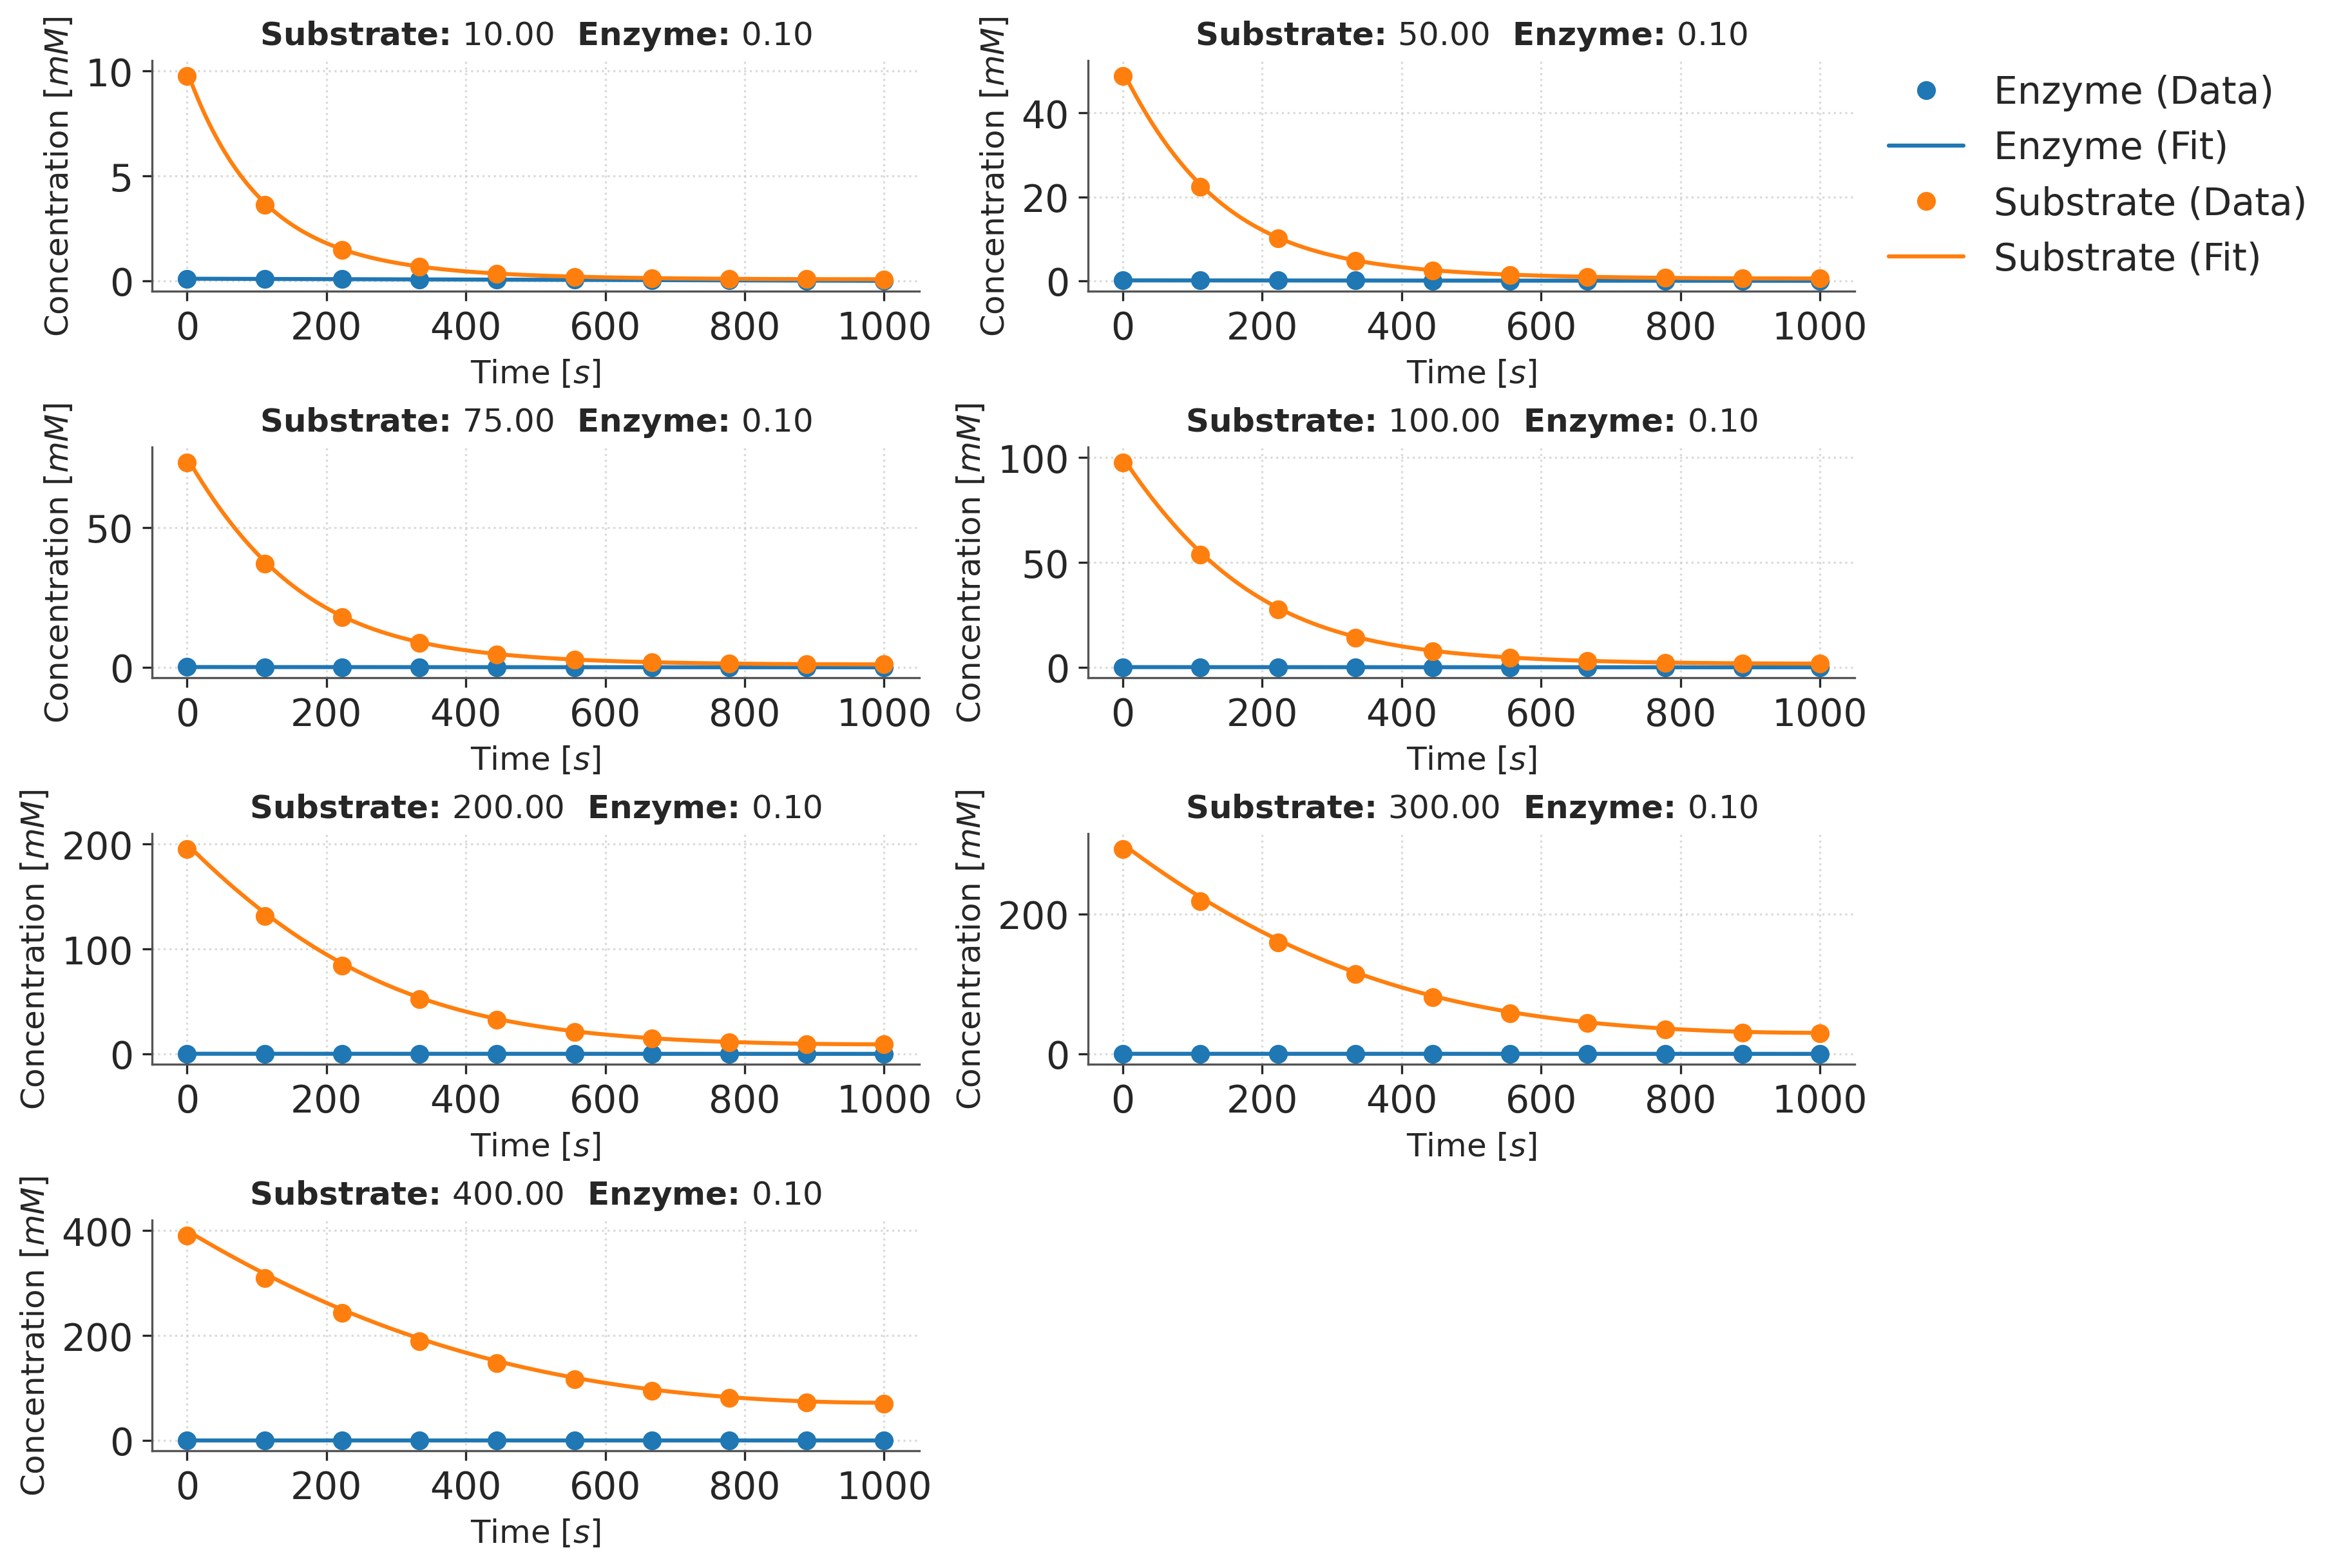

In [5]:
f = ctx.visualize(
    model=model,
    data=states,
    times=jnp.stack([time]*len(initial_conditions), axis=0),
    initial_conditions=initial_conditions,
    figsize=(3,4),
)

In [6]:
# Define Priors
model.parameters.k_cat.prior = cmc.priors.TruncatedNormal(mu=10.0, sigma=5.0, low=5.0, high=30.0)
model.parameters.K_m.prior = cmc.priors.TruncatedNormal(mu=100.0, sigma=10.0, low=10.0, high=1000.0)
model.parameters.k_d.prior = cmc.priors.Uniform(low=1e-5, high=9e-3)

mcmc, _ = cmc.run_mcmc(
    model=model,
    data=data,
    initial_conditions=initial_conditions,
    times=jnp.stack([time]*len(initial_conditions), axis=0),
    yerrs=0.97,
    num_warmup=1000,
    num_samples=1000,
    dt0=1.0,
    dense_mass=True,
    max_steps=63**4,
)

🔸 Priors
├── K_m: N(μ=100.0, σ=10.0, high=1000.0 low=10.0)
├── k_cat: N(μ=10.0, σ=5.0, high=30.0 low=5.0)
├── k_d: U(low=1e-05, high=0.009)

🚀 Running MCMC



sample: 100%|██████████| 2000/2000 [00:14<00:00, 134.82it/s, 7 steps of size 5.38e-01. acc. prob=0.94]



🎉 Finished

                mean       std    median      5.0%     95.0%     n_eff     r_hat
       K_m    104.84      3.15    104.76     99.98    110.52   1276.17      1.00
     k_cat     10.48      0.12     10.48     10.28     10.67   1222.66      1.00
       k_d      0.00      0.00      0.00      0.00      0.00   1147.99      1.00
     sigma      1.93      0.17      1.91      1.67      2.20    865.77      1.00

Number of divergences: 0


array([<Axes: title={'center': 'K_m'}>, <Axes: title={'center': 'k_cat'}>,
       <Axes: title={'center': 'k_d'}>], dtype=object)

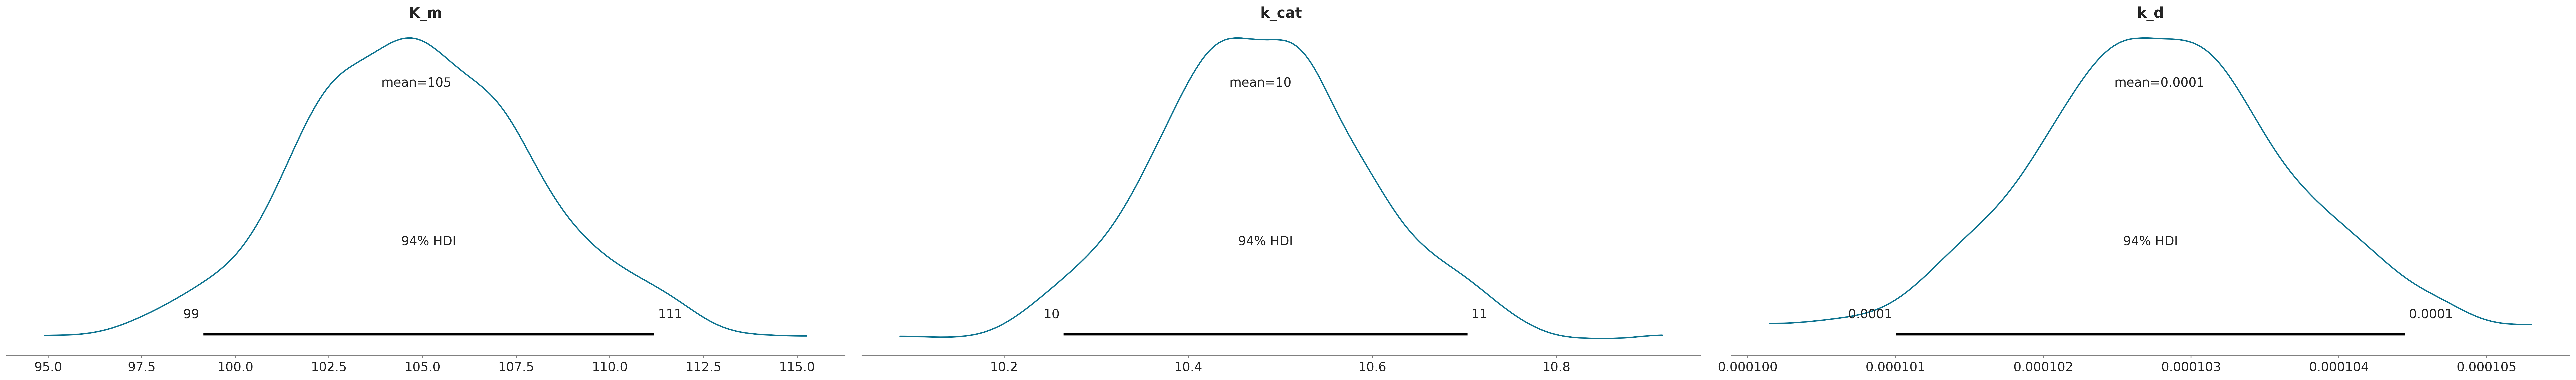

In [7]:
# Plot the posterior distributions
cmc.plot_posterior(mcmc, model)

/Users/janrange/anaconda3/envs/catalax/lib/python3.11/site-packages/corner/core.py:133: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(
/Users/janrange/GitHub/Catalax/catalax/mcmc/plotting.py:35: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


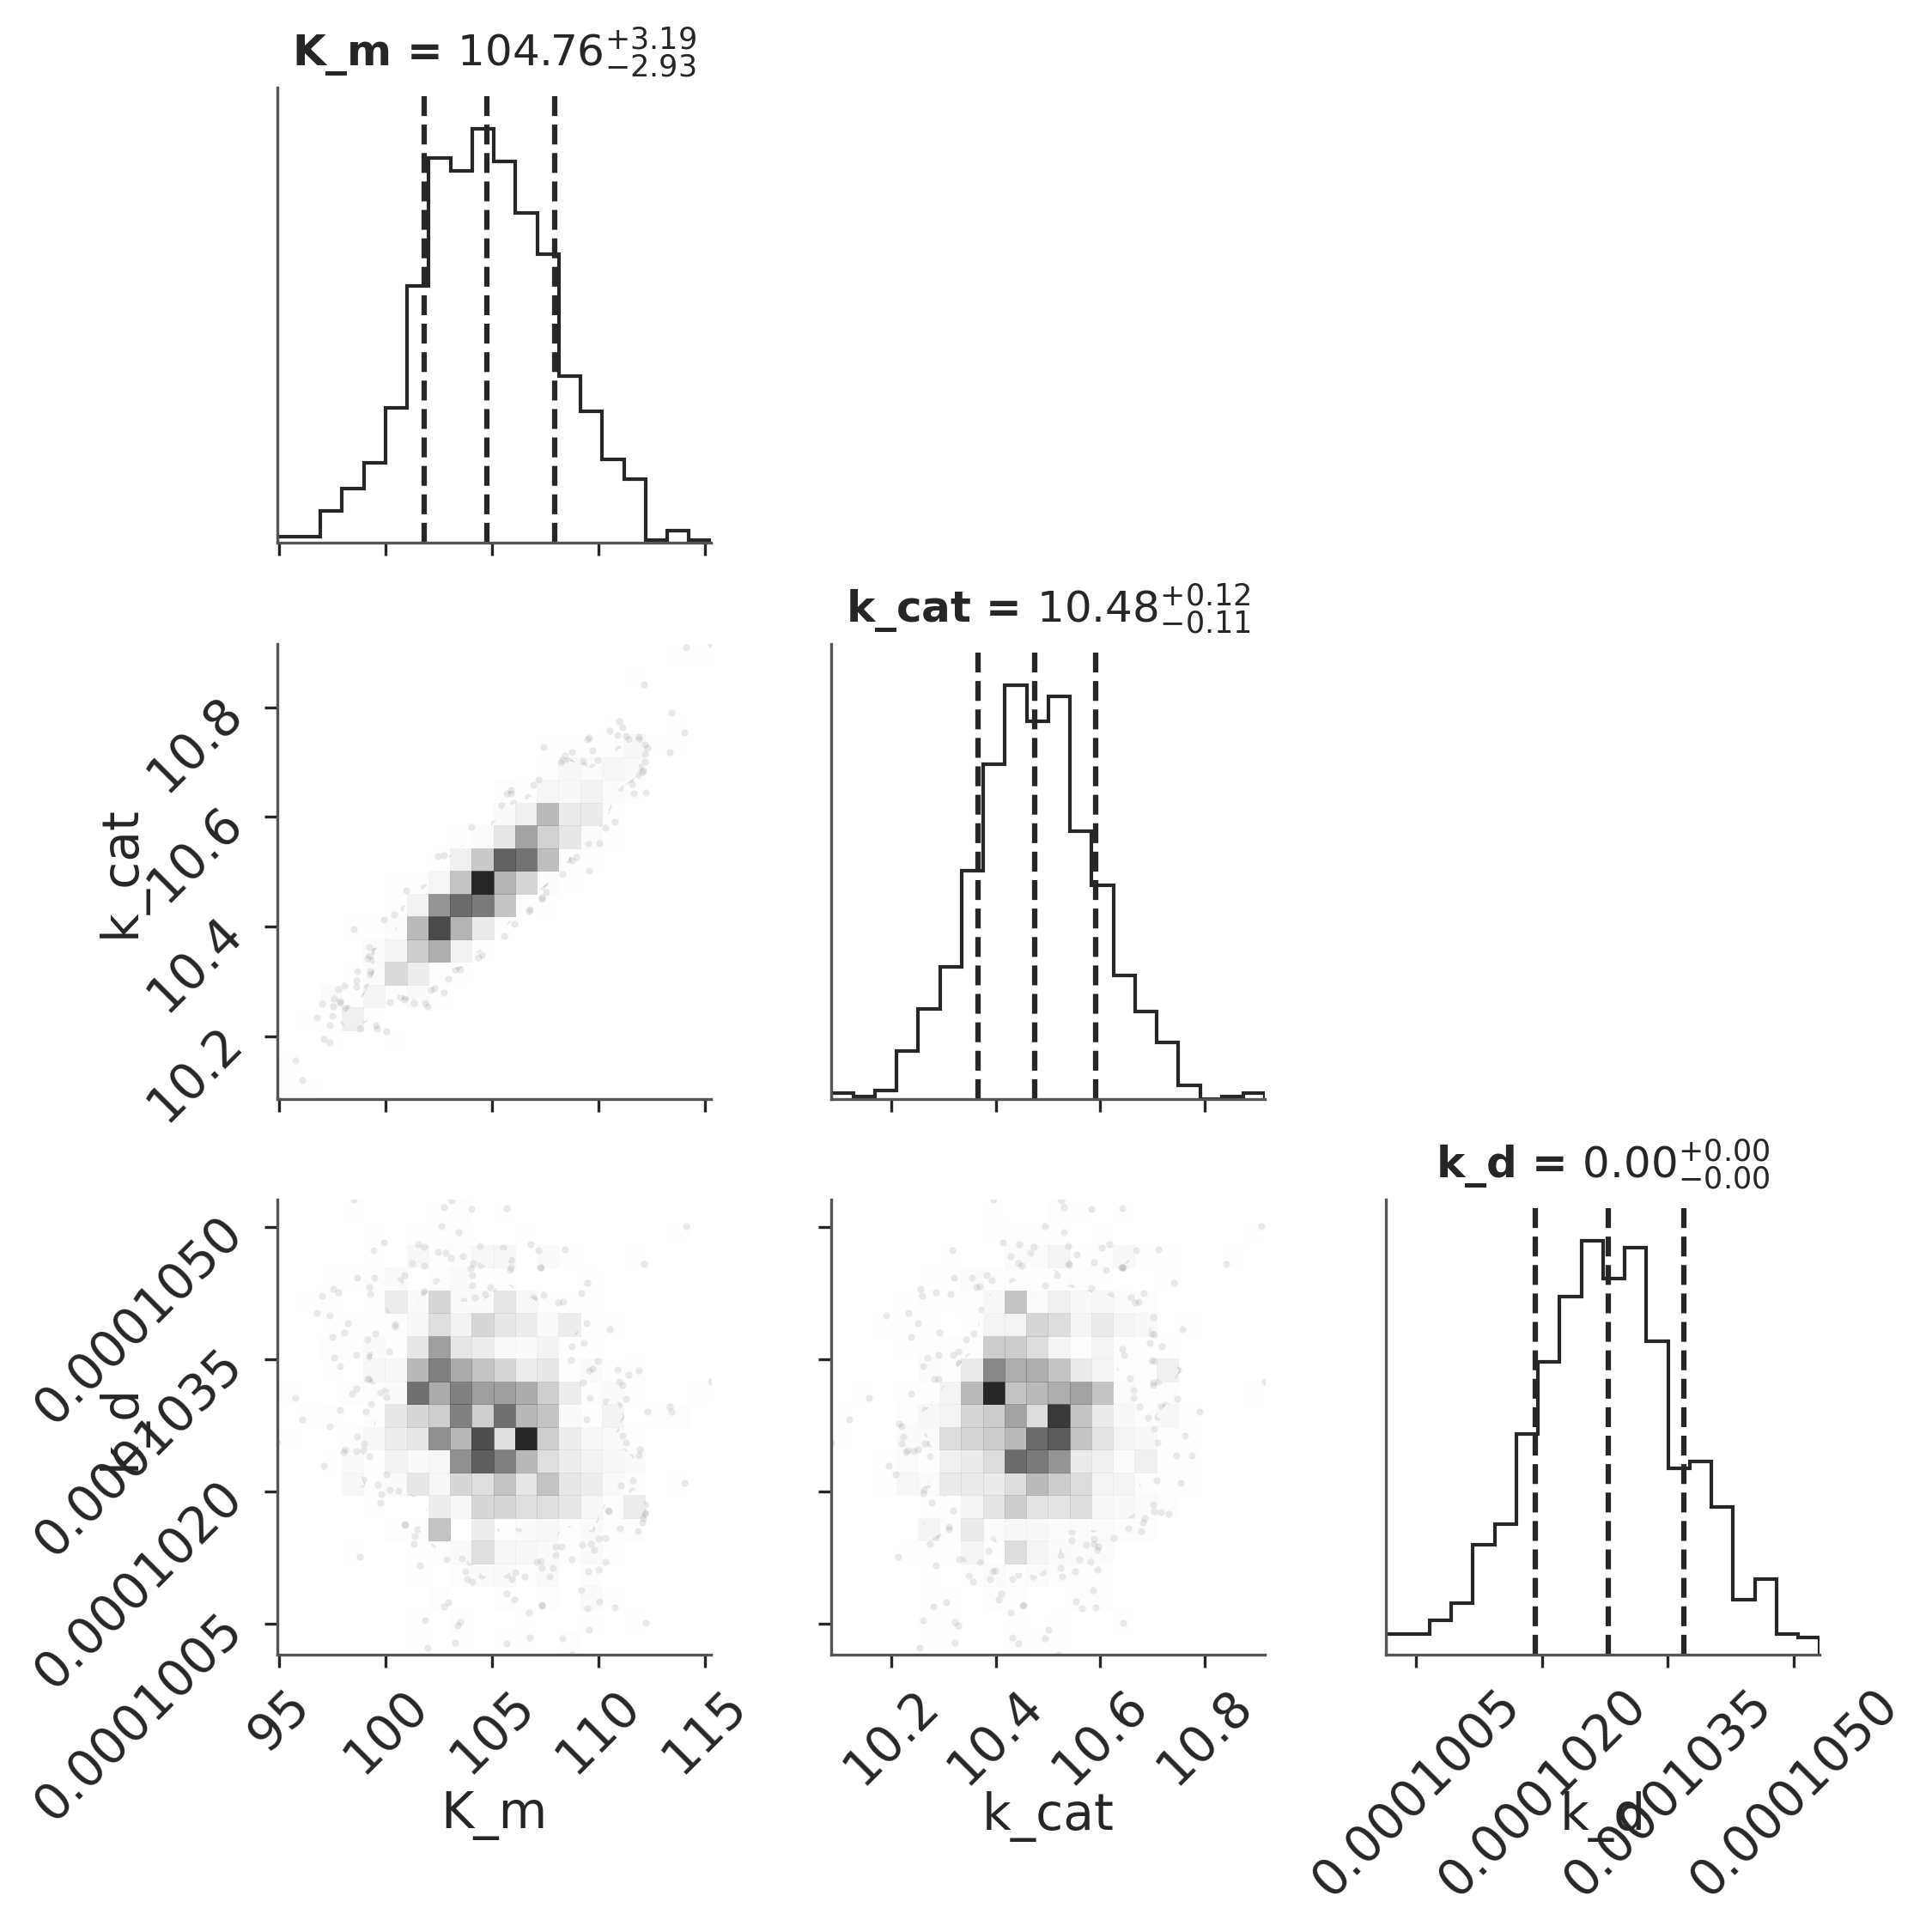

In [8]:
# Corner plot for the parameters and correlations
f = cmc.plot_corner(mcmc)